In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'AI/Lidar_3D_Object_Detection'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


%cd /content/drive/My\ Drive/$FOLDERNAME/
#!bash get_datasets.sh
#%cd /content

Mounted at /content/drive
/content/drive/My Drive/AI/Lidar_3D_Object_Detection


## **Download the Kitti Dataset [link text](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d)**

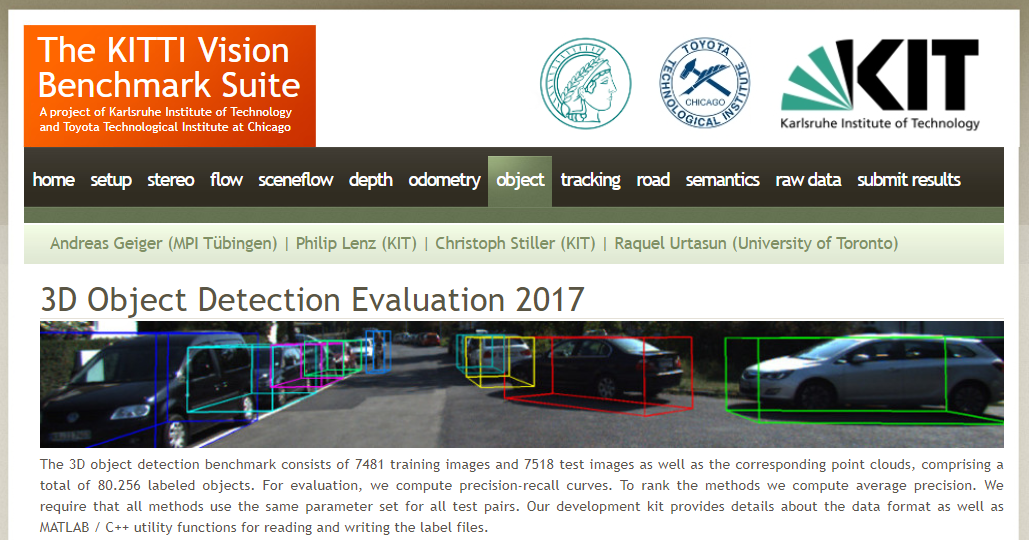

In [ ]:
#clone the voxelnet git repo (already cloned it)
#!git clone https://github.com/gkadusumilli/Voxelnet.git

Cloning into 'Voxelnet'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 91 (delta 2), reused 1 (delta 0), pack-reused 80
Unpacking objects: 100% (91/91), done.


Build the dependencies

In [ ]:
#!python Voxelnet/setup.py build_ext --inplace        #don't need to build the dependencies this case

Traceback (most recent call last):
  File "Voxelnet/setup.py", line 7, in <module>
    ext_modules=cythonize('./utils/box_overlaps.pyx'),
  File "/usr/local/lib/python3.7/dist-packages/Cython/Build/Dependencies.py", line 972, in cythonize
    aliases=aliases)
  File "/usr/local/lib/python3.7/dist-packages/Cython/Build/Dependencies.py", line 815, in create_extension_list
    for file in nonempty(sorted(extended_iglob(filepattern)), "'%s' doesn't match any files" % filepattern):
  File "/usr/local/lib/python3.7/dist-packages/Cython/Build/Dependencies.py", line 114, in nonempty
    raise ValueError(error_msg)
ValueError: './utils/box_overlaps.pyx' doesn't match any files


In [ ]:
#change the cwd
%cd /content/drive/My\ Drive/$FOLDERNAME/crop_data/

/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data


## **Start of Data Download & Unzip**

In [ ]:
#download the Velodyne training data (29GB): input to the model
#!wget  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_velodyne.zip

#unzip the Velodyne training data
#!unzip /content/drive/My\ Drive/$FOLDERNAME/crop_data/data_object_velodyne.zip 'training/*' -d /content/drive/My\ Drive/$FOLDERNAME/crop_data/

In [ ]:
# Download Left color images of the object data set (12 GB): for visualization of predictions
#!wget  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip

#Unzip the image training folder
#!unzip /content/drive/My\ Drive/$FOLDERNAME/crop_data/data_object_image_2.zip 'training/*' -d /content/drive/My\ Drive/$FOLDERNAME/crop_data

In [ ]:
#Training labels of the object data set (5 MB): input label to VoxelNet
#!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip

#unzip the object label
#!unzip /content/drive/My\ Drive/$FOLDERNAME/crop_data/data_object_label_2.zip 

Archive:  /content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/data_object_label_2.zip
replace /content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/training/label_2/003206.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Camera calibration matrices of the object data set (16 MB): for visualization of predictions
#!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_calib.zip

#unzip the data object calib
#!unzip /content/drive/My\ Drive/$FOLDERNAME/crop_data/data_object_calib.zip 'training/*' -d /content/drive/My\ Drive/$FOLDERNAME/crop_data

In [25]:
%cd /content/drive/My\ Drive/$FOLDERNAME/crop_data/

/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data


**Crop the Point Cloud data. Point clouds outside the image coordinates are removed**

In [ ]:
#to run the 'crop.py' lower version of scipy is needed
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 140kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
import numpy as np
from scipy.misc import imread
import math

CAM = 2

def load_velodyne_points(filename):
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    #points = points[:, :3]  # exclude luminance
    return points

def load_calib(calib_dir):
    # P2 * R0_rect * Tr_velo_to_cam * y
    lines = open(calib_dir).readlines()
    lines = [ line.split()[1:] for line in lines ][:-1]
    #
    P = np.array(lines[CAM]).reshape(3,4)
    #
    Tr_velo_to_cam = np.array(lines[5]).reshape(3,4)
    Tr_velo_to_cam = np.concatenate(  [ Tr_velo_to_cam, np.array([0,0,0,1]).reshape(1,4)  ]  , 0     )
    #
    R_cam_to_rect = np.eye(4)
    R_cam_to_rect[:3,:3] = np.array(lines[4][:9]).reshape(3,3)
    #
    P = P.astype('float32')
    Tr_velo_to_cam = Tr_velo_to_cam.astype('float32')
    R_cam_to_rect = R_cam_to_rect.astype('float32')
    return P, Tr_velo_to_cam, R_cam_to_rect

def prepare_velo_points(pts3d_raw):
    '''Replaces the reflectance value by 1, and tranposes the array, so
        points can be directly multiplied by the camera projection matrix'''
    pts3d = pts3d_raw
    # Reflectance > 0
    indices = pts3d[:, 3] > 0
    pts3d = pts3d[indices ,:]
    pts3d[:,3] = 1
    return pts3d.transpose(), indices

def project_velo_points_in_img(pts3d, T_cam_velo, Rrect, Prect):
    '''Project 3D points into 2D image. Expects pts3d as a 4xN
        numpy array. Returns the 2D projection of the points that
        are in front of the camera only an the corresponding 3D points.'''
    # 3D points in camera reference frame.
    pts3d_cam = Rrect.dot(T_cam_velo.dot(pts3d))
    # Before projecting, keep only points with z>0
    # (points that are in fronto of the camera).
    idx = (pts3d_cam[2,:]>=0)
    pts2d_cam = Prect.dot(pts3d_cam[:,idx])
    return pts3d[:, idx], pts2d_cam/pts2d_cam[2,:], idx


def align_img_and_pc(img_dir, pc_dir, calib_dir):
    
    img = imread(img_dir)
    pts = load_velodyne_points( pc_dir )
    P, Tr_velo_to_cam, R_cam_to_rect = load_calib(calib_dir)

    pts3d, indices = prepare_velo_points(pts)
    pts3d_ori = pts3d.copy()
    reflectances = pts[indices, 3]
    pts3d, pts2d_normed, idx = project_velo_points_in_img( pts3d, Tr_velo_to_cam, R_cam_to_rect, P  )
    #print reflectances.shape, idx.shape
    reflectances = reflectances[idx]
    #print reflectances.shape, pts3d.shape, pts2d_normed.shape
    assert reflectances.shape[0] == pts3d.shape[1] == pts2d_normed.shape[1]

    rows, cols = img.shape[:2]

    points = []
    for i in range(pts2d_normed.shape[1]):
        c = int(np.round(pts2d_normed[0,i]))
        r = int(np.round(pts2d_normed[1,i]))
        if c < cols and r < rows and r > 0 and c > 0:
            color = img[r, c, :]
            point = [ pts3d[0,i], pts3d[1,i], pts3d[2,i], reflectances[i], color[0], color[1], color[2], pts2d_normed[0,i], pts2d_normed[1,i]  ]
            points.append(point)

    points = np.array(points)
    return points

# update the following directories
IMG_ROOT = '/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/training/image_2/' 
PC_ROOT = '/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/training/velodyne/'
CALIB_ROOT = '/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/training/calib/'



for frame in range(0, 101):   #taking 0-100 datapoints of the training set for faster training (total 7481 datapoints, cropped upto 617)
    print('i: ',frame)
    img_dir = IMG_ROOT + '%06d.png' % frame
    pc_dir = PC_ROOT + '%06d.bin' % frame
    calib_dir = CALIB_ROOT + '%06d.txt' % frame

    points = align_img_and_pc(img_dir, pc_dir, calib_dir)
    #digits=int(math.log10(frame))+1
    
    #output_name = PC_ROOT + str(frame) + '.bin'
    output_name = PC_ROOT + str(frame).zfill(6) + '.bin'
    print('output', output_name)
    points[:,:4].astype('float32').tofile(output_name)

Creating a validation folder, copy training datapoints there, splitting into train & val set

In [ ]:
%cp -av /content/drive/My\ Drive/AI/Lidar_3D_Object_Detection/crop_data/training /content/drive/My\ Drive/AI/Lidar_3D_Object_Detection/crop_data/training_copy/

In [ ]:
import os
#import train

lines_train = [line.rstrip('\n') for line in open('/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/train.txt')]
lines_val = [line.rstrip('\n') for line in open('/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/val.txt')]

for i in lines_train:
  print('i-train', i)
  os.remove('/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/training/image_2/'+i+'.png')
  os.remove('/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/training/label_2/'+i+'.txt')
  os.remove('/content/drive/MyDrive/AI/Lidar_3D_Object_Detection/crop_data/training/velodyne/'+i+'.bin')

for i in lines_val:
  print('i-val',i)
  os.remove('/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/validation/image_2/'+i+'.png')
  os.remove('/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/validation/label_2/'+i+'.txt')
  os.remove('/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/validation/velodyne/'+i+'.bin')

In [ ]:
#counting how many training & val images are there
import os

#training
path, dirs, files = next(os.walk("/content/drive/MyDrive/AI/Lidar_3D_Object_Detection/crop_data/training/velodyne/"))
file_count = len(files)
print('no of training images', file_count)

#val
path, dirs, files = next(os.walk("/content/drive/MyDrive/AI/Lidar_3D_Object_Detection/crop_data/validation/velodyne/"))
file_count = len(files)
print('no of validation images', file_count)

In [39]:
import os.path
from os import path
#path.exists("/content/drive/My Drive/subhodip_photo123.png")
path.exists("/content/drive/My Drive/AI/Lidar_3D_Object_Detection/crop_data/train.txt")

True